### Setup

In [3]:
print('Train several models, perform cross validation, and save the highest performing model!!')

Train several models, perform cross validation, and save the highest performing model!!


In [5]:
import sklearn as sk
import numpy as np
import pandas as pd
import pickle
import matplotlib
import matplotlib.pyplot as plt


## Import Data

In [3]:
df = pd.read_csv('/mnt/data/smallPrepared.csv', header=0, index_col=0)
print("df has {} rows and {} Columns".format(df.shape[0], df.shape[1]))
df.head()

df has 7939 rows and 6 Columns


,dropperc,mins,consecmonths,income,age,churn_Y
custid,,,,,,
844336,0.016364,550,28,89.2,45,0
146041,0.018349,545,33,54.2,43,0
847745,0.018519,378,41,55.3,41,0
285565,0.014493,552,32,66.8,31,0
754611,0.012132,577,4,87.2,43,0


### Begin Model Building

In [4]:
columns = list(df.columns)
columns.remove('churn_Y')
y = df["churn_Y"].values
X = df[columns].values

In [5]:
from sklearn.ensemble import AdaBoostClassifier
ad1 = AdaBoostClassifier(learning_rate=1)
ad1 = ad1.fit(X, y)
ad1prb = ad1.predict_proba(X)

In [6]:
from sklearn.ensemble import AdaBoostClassifier
ad2 = AdaBoostClassifier(learning_rate=0.5)
ad2 = ad2.fit(X, y)
ad2prb = ad2.predict_proba(X)

In [7]:
from sklearn.ensemble import GradientBoostingClassifier
gb1 = GradientBoostingClassifier(loss = 'exponential', max_depth=3)
gb1 = gb1.fit(X, y)
gb1prb = gb1.predict_proba(X)

In [8]:
from sklearn.ensemble import GradientBoostingClassifier
gb2 = GradientBoostingClassifier(loss = 'exponential', max_depth=10)
gb2 = gb2.fit(X, y)
gb2prb = gb2.predict_proba(X)

In [9]:
from sklearn.ensemble import RandomForestClassifier 
rf1 = RandomForestClassifier(max_depth=None)
rf1 = rf1.fit(X, y)
rf1prb = rf1.predict_proba(X)
rf1pclass = rf1.predict(X)

In [10]:
from sklearn.ensemble import RandomForestClassifier 
rf2 = RandomForestClassifier(max_depth = 5)
rf2 = rf2.fit(X, y)
rf2prb = rf2.predict_proba(X)
rf2pclass = rf2.predict(X)

In [11]:
from sklearn.ensemble import RandomForestClassifier 
rf3 = RandomForestClassifier(max_depth = 30)
rf3 = rf3.fit(X, y)
rf3prb = rf3.predict_proba(X)
rf3pclass = rf3.predict(X)

### Build a Cross Validation Function

In [12]:
from sklearn.model_selection import cross_val_score

# takes a dict of models and their short names, the input np.array, the target np.array, the type of score to be used with cv, and # of folds
# each element in the dict of models should have two items: the model object and the short name you want to use for that model object
# returns a dataframe with the names you entered and the mean of the cv scores across all folds

def cv_fun(models, inputs, target, score, folds):
    
    scores_dict = dict()
    
    for k,v in models.items():
        scores = cross_val_score(v, inputs, target, scoring=score, cv=folds)
        scores_dict.update({k: round(scores.mean(),3)})

    return pd.DataFrame(scores_dict.values(), index= scores_dict.keys(), columns=[score])

In [13]:
## quick test
small_models_dict = {}
small_models_dict.update({'rf1' : rf1})
small_models_dict.update({'rf2' : rf2})

test = cv_fun(small_models_dict, X, y, 'accuracy', 2)
test

,accuracy
rf1,0.959
rf2,0.956


### Cross Validation on the Training Data

In [14]:
%%time

models_dict = {}
models_dict.update({'ad1' : ad1})
models_dict.update({'ad2' : ad2})
models_dict.update({'gb1' : gb1})
# models_dict.update({'gb2' : gb2})
models_dict.update({'rf1' : rf1})
models_dict.update({'rf2' : rf2})
models_dict.update({'rf3' : rf3})

cv_auc = cv_fun(models_dict, X, y, 'roc_auc', 2)
cv_acc = cv_fun(models_dict, X, y, 'accuracy', 2)

cv_results = cv_auc.join(cv_acc)
cv_results.sort_values(by='roc_auc', ascending=False, inplace=True)

CPU times: user 7.82 s, sys: 16 ms, total: 7.83 s
Wall time: 7.83 s


In [15]:
cv_results

,roc_auc,accuracy
ad2,0.939,0.960
gb1,0.939,0.958
ad1,0.934,0.956
rf2,0.931,0.955
rf1,0.919,0.957
rf3,0.918,0.958


In [16]:
#automated model selection
model_name = cv_results.index.values[0]
best_model = models_dict.get(model_name)

In [17]:
best_model_auc = cv_results.loc[model_name].roc_auc
best_model_acc = cv_results.loc[model_name].accuracy

print(" Accuracy: {} \n AUC: {}".format(best_model_acc, best_model_auc))

 Accuracy: 0.96 
 AUC: 0.939


In [18]:
#option to add f1 score 

best_model_f1 = round(cv_fun({model_name : best_model}, X, y, 'f1',2).values[0][0], 3)
print(" Accuracy: {} \n AUC: {} \n F1: {}".format(best_model_acc, best_model_auc, best_model_f1))

 Accuracy: 0.96 
 AUC: 0.939 
 F1: 0.448


In [19]:
print(best_model, model_name)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.5,
                   n_estimators=50, random_state=None) ad2


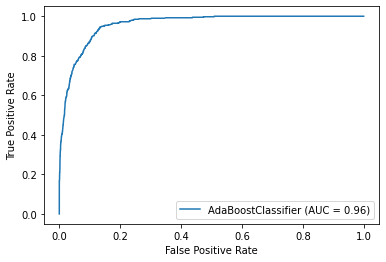

In [20]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(best_model, X, y)

In [21]:
from sklearn import metrics
from sklearn.model_selection import KFold

classifier = best_model
kf = KFold(n_splits=5)

tprs = []
aucs = []
accs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in kf.split(X):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    preds_ = classifier.fit(X[train], y[train]).predict(X[test])
    fpr, tpr, thresholds = metrics.roc_curve(y[test], probas_[:, 1])
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    accuracy = metrics.accuracy_score(y[test], preds_)
    accs.append(accuracy)
    i += 1
    
mean_acc = np.mean(accs)
std_acc = np.std(accs)
mean_tpr = np.mean(tprs, axis = 0)
mean_tpr[-1] = 1.0
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.logistic module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.0 when using version 0.22.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


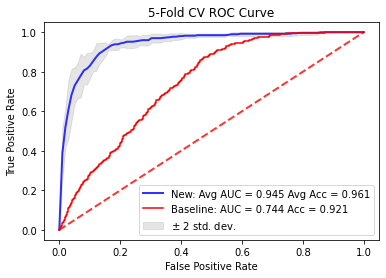

In [22]:
# baseline data
df_baseline = pd.read_csv('/mnt/data/churndata.csv', header=0, index_col=0, nrows = X.shape[0])
create_dummies = pd.get_dummies(df_baseline['churn'],prefix='churn', drop_first=True)  
df_baseline=pd.concat([df_baseline,create_dummies],axis=1)
df_baseline = df_baseline.drop(['churn'], axis=1)
baseline_cols = ['consecmonths', 'KPI_DeviceSat', 'KPI_NetworkQual']
y_baseline = df_baseline['churn_Y'].values
X_baseline = df_baseline[baseline_cols].values

#import baseline model and perform cv
baseline_model =pickle.load(open('/mnt/Models/baseline.pkl', 'rb'))
tprs_baseline = []
aucs_baseline = []
accs_baseline = []
mean_fpr_baseline = np.linspace(0, 1, 100)
 
probas_baseline = baseline_model.predict_proba(X_baseline)
preds_baseline = baseline_model.predict(X_baseline)
fpr_baseline, tpr_baseline, thresholds_baseline = metrics.roc_curve(y_baseline, probas_baseline[:, 1])
tprs_baseline.append(np.interp(mean_fpr_baseline, fpr_baseline, tpr_baseline))
tprs[-1][0] = 0.0
roc_auc_baseline = metrics.auc(fpr_baseline, tpr_baseline)
aucs_baseline.append(roc_auc_baseline)
accuracy_baseline = metrics.accuracy_score(y, preds_baseline)
accs_baseline.append(accuracy_baseline)
acc_baseline = np.mean(accs_baseline)
auc_baseline = np.mean(aucs_baseline)

# Make ROC Plot with baseline and best_model
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
plt.plot(mean_fpr, mean_tpr, color='b', lw=2, alpha=.8, label='New: Avg AUC = %0.3f Avg Acc = %0.3f' % (mean_auc, mean_acc))
plt.plot(fpr_baseline,tpr_baseline,color='red', label=        'Baseline: AUC = %0.3f Acc = %0.3f' % (auc_baseline, acc_baseline))
#plt.text(0.6, 0.125, 'Mean AUC = %0.3f' % (mean_auc))
#plt.text(0.6, 0.2, 'Mean Accuracy = %0.3f' % (mean_acc))
 
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + 2*std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - 2*std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 2 std. dev.')
 
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("5-Fold CV ROC Curve")
plt.legend(loc="lower right")
 

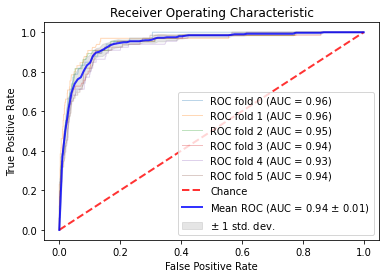

In [23]:
from sklearn.model_selection import StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc

cv = StratifiedKFold(n_splits=6)
classifier = best_model

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    viz = plot_roc_curve(classifier, X[test], y[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver Operating Characteristic")
ax.legend(loc="lower right")
plt.show()

### Save Best Model to File

In [24]:
import pickle 

# save best model
file = '/mnt/Models/BestModelCV.pkl'
pickle.dump(best_model, open(file, 'wb')) # w = open for writing, r = open for reading, b = binary

In [25]:

#make confusion matrix plot
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot
 
    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix
 
    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']
 
    title:        the text to display at the top of the matrix
 
    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues
 
    normalize:    If False, plot the raw numbers
                  If True, plot the proportions
 
    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph
 
    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
 
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools
 
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
 
    if cmap is None:
        cmap = plt.get_cmap('Blues')
 
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
 
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
 
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
 
 
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
 
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.gcf().subplots_adjust(bottom=0.25)
    plt.savefig('/mnt/output/ConfMatx_Best.png', format='png')
    plt.show()
    #plt.gcf().clear()
    


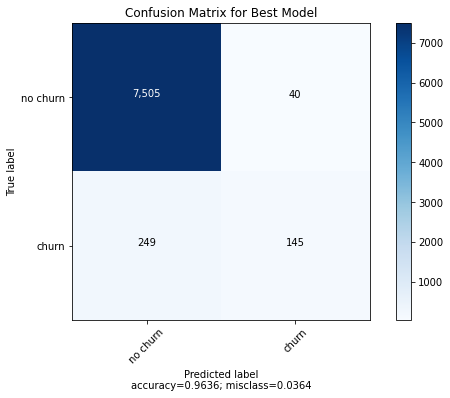

In [26]:
from sklearn import metrics

plot_confusion_matrix(cm           = metrics.confusion_matrix(y, best_model.predict(X)), 
                      normalize    = False,
                      target_names = ['no churn', 'churn'],
                      title        = "Confusion Matrix for Best Model")
                      

In [27]:
df2 = df
#note slight mod to line below to pull model object from 'selected' variable. 2nd item in list contains name. 

df2["prob"] = best_model.predict_proba(X)[:,1]
df2.to_csv('/mnt/data/modelOut.csv')

In [28]:
df2.head()

,dropperc,mins,consecmonths,income,age,churn_Y,prob
custid,,,,,,,
844336,0.016364,550,28,89.2,45,0,0.452854
146041,0.018349,545,33,54.2,43,0,0.438619
847745,0.018519,378,41,55.3,41,0,0.428265
285565,0.014493,552,32,66.8,31,0,0.456542
754611,0.012132,577,4,87.2,43,0,0.160126


In [29]:
df2.shape

(7939, 7)